In [367]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import Model
import matplotlib.pyplot as plt
%matplotlib widget
from PIL import Image

In [368]:
tf.random.set_seed(272) # DO NOT CHANGE THIS VALUE
img_size = 400
vgg = tf.keras.applications.VGG19(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')
vgg.trainable = False

$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$

In [369]:
def compute_content_cost(content_output, generated_output):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    # DON'T USE NUMPY API HERE AS IT WILL BE USED BY TENSORFLOW TO CALCULATE GRADIENTS.
    content_output = content_output[-1]
    generated_output = generated_output[-1]
    _, n_H, n_W, n_C = content_output.get_shape().as_list()
    content_output = tf.reshape(content_output, (_, -1, n_C))
    generated_output = tf.reshape(generated_output, (_, -1, n_C))
    J_c = tf.reduce_sum(tf.square(tf.subtract(content_output, generated_output)))/(4*n_H*n_W*n_C)
    return J_c

In [370]:
# UNQ_C1
# GRADED FUNCTION: compute_content_cost

def compute_content_cost(content_output, generated_output):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    a_C = content_output[-1]
    a_G = generated_output[-1]
    
    ### START CODE HERE
    
    # Retrieve dimensions from a_G (≈1 line)
    _, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G (≈2 lines)
    a_C_unrolled = tf.reshape(a_C, shape=[_, n_H * n_W, n_C]) 
    a_G_unrolled = tf.reshape(a_G, shape=[_, -1, n_C]) 
    
    # compute the cost with tensorflow (≈1 line)
    J_content =  tf.reduce_sum(tf.square(a_C_unrolled - a_G_unrolled))/(4.0 * n_H * n_W * n_C)
    
    ### END CODE HERE
    
    return J_content

In [371]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    GA = tf.matmul(A, tf.linalg.matrix_transpose(A))
    return GA

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{(gram)i,j} - G^{(G)}_{(gram)i,j})^2\tag{2} $$

In [372]:

def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    _, n_H, n_W, n_C = a_S.get_shape().as_list()
    a_S = tf.reshape(a_S, (-1, n_C))
    a_G = tf.reshape(a_G, (-1, n_C))
    gram_mat_S = gram_matrix(tf.transpose(a_S))
    gram_mat_G = gram_matrix(tf.transpose(a_G))
    J_s = tf.reduce_sum(tf.square(tf.subtract(gram_mat_S, gram_mat_G)))/(4*(n_C**2)*((n_H*n_W)**2))
    return J_s

    

In [373]:
for layer in vgg.layers:
    print(layer.name)

input_17
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [374]:
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

In [375]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    style_image_output -- our tensorflow model
    generated_image_output --
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    J_style = 0
    a_S = style_image_output[:-1]
    a_G = generated_image_output[:-1]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):  
        layer_cost = compute_layer_style_cost(a_S[i], a_G[i])
        J_style += weight[1]*layer_cost
    return J_style

$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

In [376]:
@tf.function
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    J_t = alpha*J_content + beta*J_style
    return J_t

(1, 400, 400, 3)


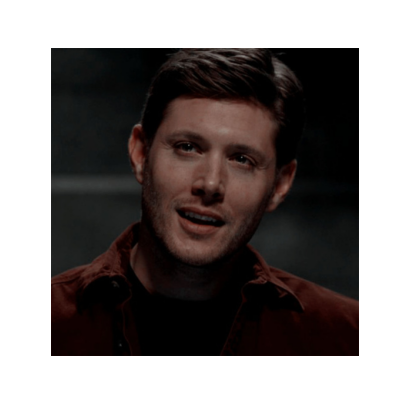

In [377]:
content_image = np.array(Image.open("images/dean_winc.jpg").resize((img_size, img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))
print(content_image.shape)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.axis('off')
ax.imshow(content_image[0])

(1, 400, 400, 3)


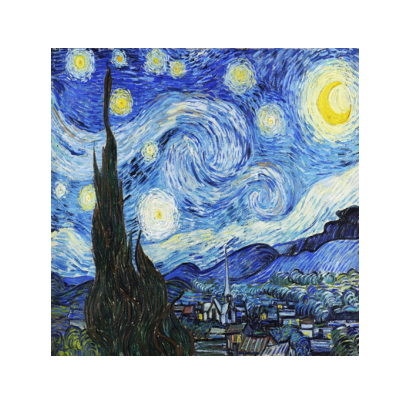

In [378]:
style_image =  np.array(Image.open("images/my_style.jpg").resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.axis('off')
ax.imshow(style_image[0])

(1, 400, 400, 3)


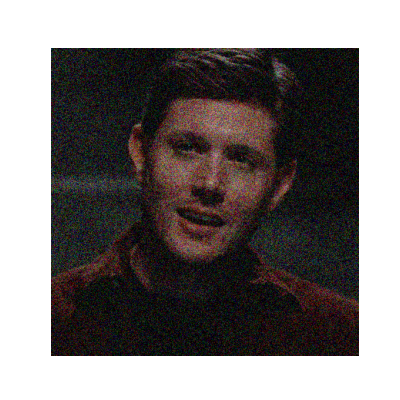

In [379]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), -0.25, 0.25)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print(generated_image.shape)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.axis('off')
ax.imshow(generated_image.numpy()[0])

In [380]:
def get_layer_outputs(vgg, layer_names):
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]
    return Model(inputs=vgg.input, outputs=outputs)

In [381]:
content_layer = [('block5_conv4', 1)]
vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS+content_layer)

In [382]:
content_target = vgg_model_outputs(content_image)  # Content encoder
style_targets = vgg_model_outputs(style_image)     # Style encoder

In [383]:
# Assign the content image to be the input of the VGG model.  
# Set a_C to be the hidden layer activation from the layer we have selected
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

# Assign the input of the model to be the "style" image 
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

In [384]:
def clip_0_1(image):
    """
    Truncate all the pixels in the tensor to be between 0 and 1
    
    Arguments:
    image -- Tensor
    J_style -- style cost coded above

    Returns:
    Tensor
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
    """
    Converts the given tensor into a PIL image
    
    Arguments:
    tensor -- Tensor
    
    Returns:
    Image: A PIL image
    """
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

In [385]:
generated_image = tf.Variable(generated_image)

In [386]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

@tf.function
def train_step(generated_img):
    with tf.GradientTape() as tape:
        a_G = vgg_model_outputs(generated_img)
        content_cost = compute_content_cost(a_C, a_G)
        style_cost = compute_style_cost(a_S, a_G)
        J = total_cost(content_cost, style_cost, 10, 40)
    grad = tape.gradient(J, generated_img)
    optimizer.apply_gradients([(grad, generated_img)])
    generated_img.assign(clip_0_1(generated_img))
    return J

In [387]:
epochs = 20000
for i in range(epochs):
    cost = train_step(generated_image)

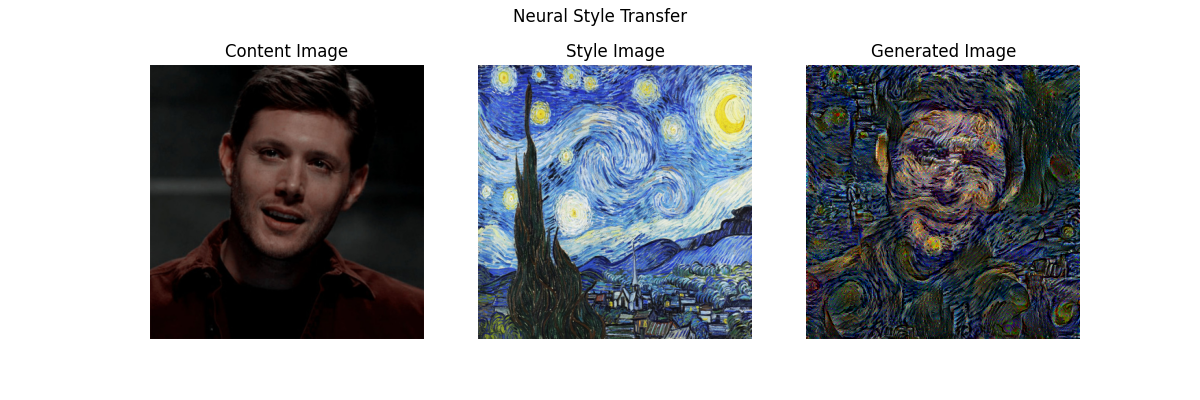

In [388]:
img = tensor_to_image(generated_image)
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle("Neural Style Transfer")
ax[0].imshow(content_image[0])
ax[0].axis('off')
ax[0].set_title("Content Image")
ax[1].imshow(style_image[0])
ax[1].axis('off')
ax[1].set_title("Style Image")
ax[2].imshow(img)
ax[2].axis('off')
ax[2].set_title("Generated Image")
fig.savefig(f"./results{epochs}epochs.jpg", dpi=200)